<a href="https://colab.research.google.com/github/eunzzae/Study_NLP/blob/main/231123_%EC%8B%A4%EC%8A%B5(1)_%ED%9D%89%EB%B6%80_X_ray_%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%A1%9C_%EC%A0%95%EC%83%81_%EC%BD%94%EB%A1%9C%EB%82%98_%ED%8F%90%EB%A0%B4%EC%9D%84_%EB%B6%84%EB%A5%98%ED%95%98%EB%8A%94_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 흉부 X-ray 이미지로 정상/코로나/폐렴을 분류하는 Image Classification

In [ ]:
Overview
Classification 소개와 적용사례, CNN를 사용하는 이유
Covid chest x-ray 데이터셋 소개 및 탐색, 문제정의
데이터셋 구축과 연산을 위한 텐서변환 적용해보기
대표적인 classifier 소개와 아키텍처 불러오기
순전파, 역전파 설명과 손실함수 불러오기
classifier 학습을 위한 코드작성해보기
검증을 위한 지표 소개 및 적용해보기
학습한 모델을 실제로 테스트해보기
Summary

## 1. 라이브러리 불러오기

In [ ]:
import os
import copy
import random

import cv2
import torch
import numpy as np
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from ipywidgets import interact

random_seed = 2022

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. 이미지 파일경로 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

In [5]:
IMAGE_FORMAT = ['jpeg', 'jpg', 'png']
def list_image_files(data_dir, sub_dir):
    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split('.')[-1] in IMAGE_FORMAT:
            image_files.append(os.path.join(images_dir, file_path))
    return image_files

In [44]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/'
normals_list = list_image_files(data_dir, "Normal")
covids_list = list_image_files(data_dir, "Covid")
pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")

print(f'Normal:{len(normals_list)}, Covid:{len(covids_list)}, Pneu:{len(pneumonias_list)}')
normals_list

Normal:70, Covid:111, Pneu:70


['/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/Normal/019.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/Normal/017.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/Normal/01.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/Normal/015.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/Normal/016.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/Normal/011.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/Normal/010.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/Normal/012.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학

## 3. 이미지파일을 RGB 3차원 배열로 불러오기

In [11]:
import cv2

In [12]:
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

## 4. 이미지데이터 확인하기

In [14]:
import matplotlib.pyplot as plt
from ipywidgets import interact

In [38]:
min_num_files = min(len(normals_list), len(pneumonias_list))
# print(min_num_files)
min_num_files

70

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

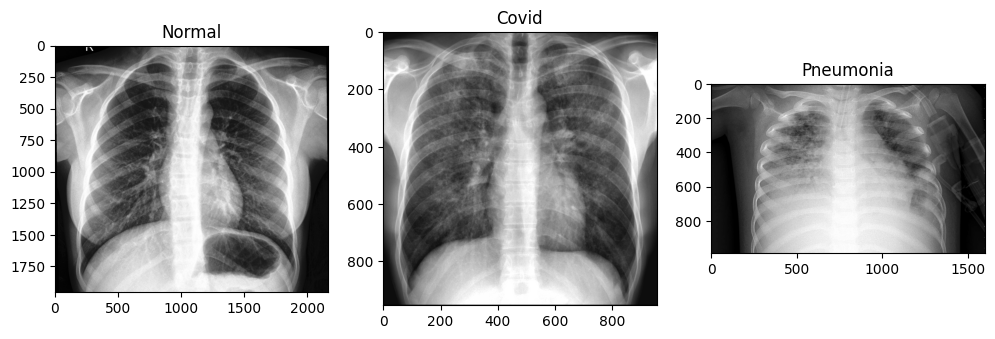

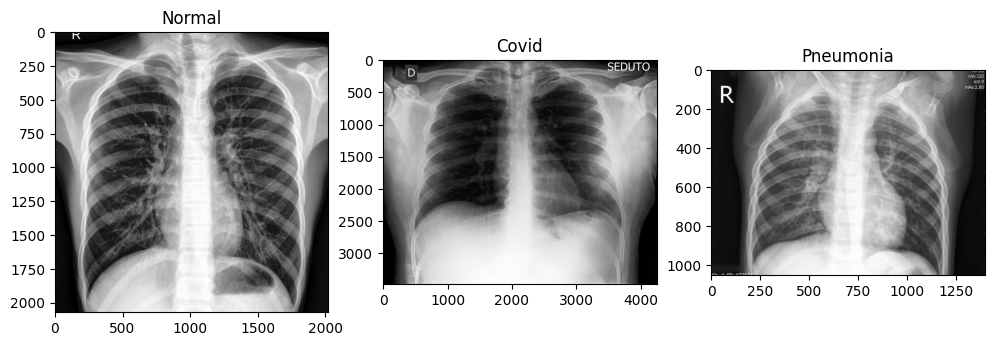

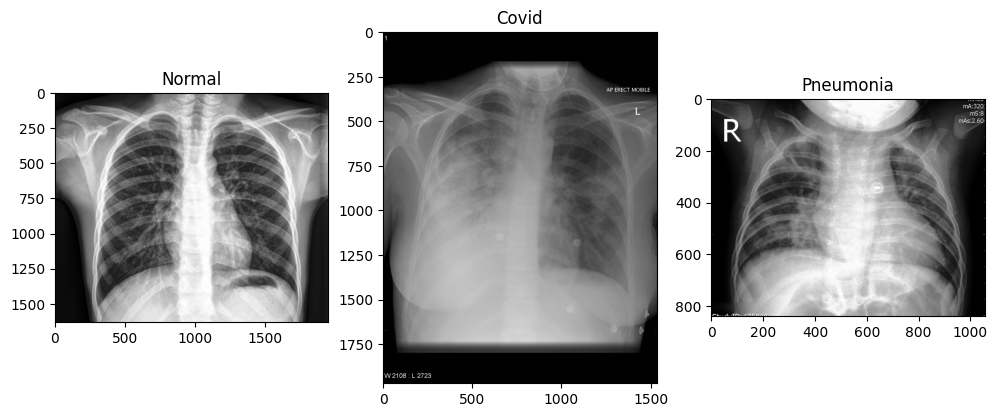

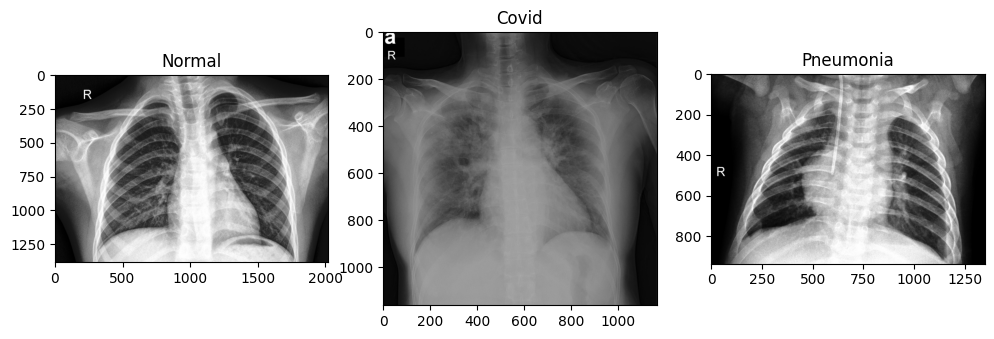

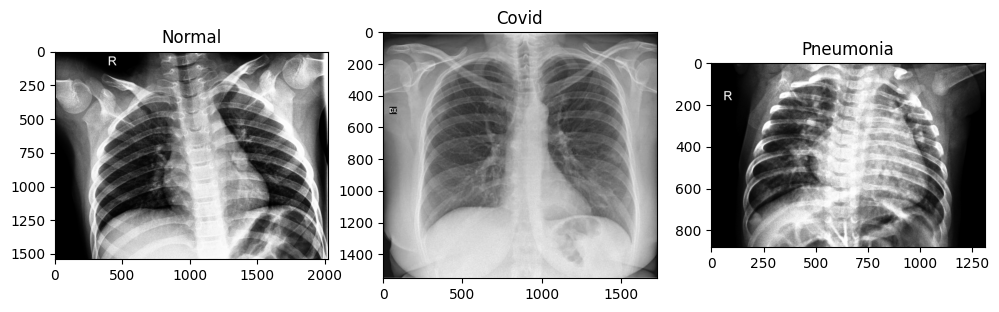

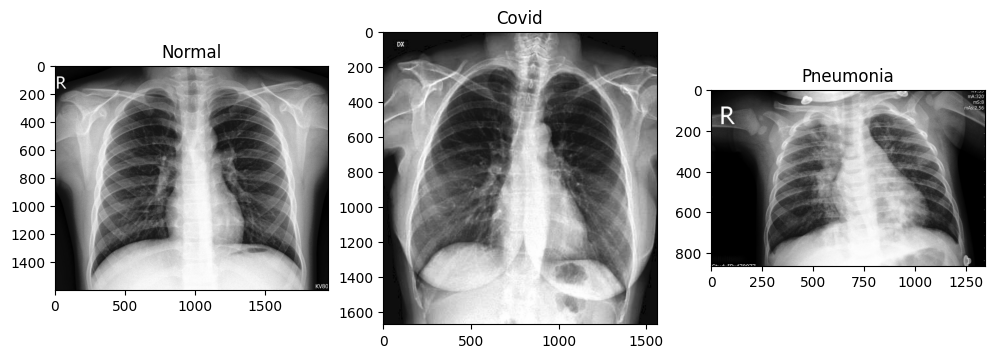

In [16]:
@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])

    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Normal')
    plt.imshow(normal_image)

    plt.subplot(132)
    plt.title('Covid')
    plt.imshow(covid_image)

    plt.subplot(133)
    plt.title('Pneumonia')
    plt.imshow(pneumonia_image)

# ---

## 5. 학습데이터셋 클래스 구축

In [17]:
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/data/Classification/train/'
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

In [40]:
class Chest_dataset():
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        normals = list_image_files(data_dir, "Normal")
        covids = list_image_files(data_dir, "Covid")
        pneumonias = list_image_files(data_dir, "Viral Pneumonia")

        self.files_path = normals + covids + pneumonias #세가지 카테고리의 이미지 파일을 하나의 리스트로 합침
        self.transform = transform #이미지 변환을 적용하기 위한 파라미터

    def __len__(self):
        return len(self.files_path)

    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index]) # 인덱스에 해당하는 이미지 파일의 전체 경로 생성
        image = cv2.imread(image_file)  #opencv를 사용해 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지를 BGR에서 RGB로 변환

        # target = class_list.index(self.files_path[index].split(os.sep)[-2])

        # target = class_list.index(self.files_path[index].split(os.sep)[0])

        class_name = self.files_path[index].split(os.sep)[0] # 해당 이미지 파일의 경로를 사용해 클래스 이름을 가져옴
        class_id = class_list.index(class_name) # 클래스 이름을 사용해 class_list에서 클래스 ID를 찾음

        if self.transform:
            image = self.transform(image) # 이미지 변환 적용
            class_id = torch.Tensor([target]).long() # 변환된 이미지에 대한 클래스 ID를 Tensor형태로 변환해서 class_id에 저장

        return image, class_id

In [41]:
dset = Chest_dataset(data_dir = train_data_dir)

In [42]:
index = 110
image, target = dset[index]

plt.title(class_list[target])
plt.imshow(image)

ValueError: ignored

In [ ]:
print(image.shape)
print(target)

## 6. 배열을 연산가능한 텐서로 변환하기

In [47]:
import torch
from torchvision import transforms

In [48]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [49]:
dset = Chest_dataset(data_dir = train_data_dir)
index = 200
image = dset[index][0]
target = dset[index][1]
print(image.shape)
print(target)

FileNotFoundError: ignored

## 7. 데이터로더 구현하기

In [50]:
from torch.utils.data import DataLoader

In [51]:
# train_data_dir = '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/'
# val_data_dir = '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/test/'

# train_dset = Chest_dataset(train_data_dir, transformer)
# train_dloader = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)

# val_dset = Chest_dataset(val_data_dir, transformer)
# val_dloader = DataLoader(val_dset, batch_size=1, shuffle=False)


In [52]:
# 작업할 때 편리하게 사용할 수 있는 팁 !
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    dataloaders['train'] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
    val_dset = Chest_dataset(val_data_dir, transformer)
    dataloaders['val'] = DataLoader(val_dset, batch_size=1, shuffle=False)
    return dataloaders

In [54]:
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/train/'
val_data_dir = '/content/drive/MyDrive/Colab Notebooks/0. [패캠강의]온라인_트랙학습/Classification/test/'
dataloaders = build_dataloader(train_data_dir, val_data_dir)
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7c7e2a5c36d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7c7e17f95480>}


# ---

## 8. Classification 모델(VGG19) 불러오기

![VGG19_architecture.png](attachment:VGG19_architecture.png)

In [55]:
from torchvision import models

In [56]:
model = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:17<00:00, 33.3MB/s]


In [57]:
from torchsummary import summary

summary(model, (3, 224, 224), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

## 9. 데이터에 맞도록 모델 Head 부분 변경하기

In [59]:
import torch.nn as nn

In [63]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 3),
    nn.Sigmoid(),
)

In [64]:
def build_vgg19_based_model(device='cpu'):
    device = torch.device(device)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 3),
        nn.Sigmoid(),
    )
    return model.to(device)

In [65]:
model = build_vgg19_based_model(device='cpu')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [66]:
summary(model, (3, 224, 224), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

# ---

## 10. 손실함수 불러오기

In [67]:
loss_func = nn.CrossEntropyLoss(reduction='mean')

## 11. Gradient 최적화 함수 불러오기

In [68]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# ---

## 12. 모델 검증을 위한 Accuracy 생성하기

# ---

## 13. 모델 학습을 위한 함수 구현하기

In [69]:
device=torch.device('cpu')

In [74]:
def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    losses = {}  # 학습 손실(losses)와 정확도(accuracies)를 담을 딕셔너리 변수 초기화
    accuracies = {}

    # 학습 및 검증 데이터셋에 대해 반복
    for phase in ["train", "val"]:
        running_loss = 0.0  # 각 에폭에서의 손실을 누적할 변수 초기화
        running_correct = 0  # 각 에폭에서의 정확한 예측 수를 누적할 변수 초기화

        if phase == "train":
            model.train()  # 모델을 학습 모드로 설정
        else:
            model.eval()  # 모델을 평가 모드로 설정

        # 각 데이터셋에서 배치 단위로 데이터를 가져와 학습 또는 평가 수행
        for index, batch in enumerate(dataloaders[phase]):
            image = batch["image"].to(device)  # 이미지 데이터를 GPU로 전송
            target = batch["target"].squeeze(1).to(device)  # 타겟 데이터를 GPU로 전송 및 차원 조정

            optimizer.zero_grad()  # 기울기 초기화

            with torch.set_grad_enabled(phase == "train"):
                prediction = model(image)  # 모델에 이미지 전달하여 예측 수행
                loss = loss_func(prediction, target)  # 손실 계산

                if phase == "train":
                    loss.backward()  # 역전파 수행
                    optimizer.step()  # 옵티마이저 단계 실행

            running_loss += loss.item()  # 손실 누적
            running_correct += get_accuracy(image, target, model)  # 정확도 누적

            # 학습 중일 때 일정 간격으로 현재 손실 출력
            if phase == "train" and index % 10 == 0:
                print(f"{index}/{len(dataloaders[phase])} - Running Loss: {loss.item()}")

        # 각 에폭에서의 평균 손실과 정확도 계산 및 저장
        losses[phase] = running_loss / len(dataloaders[phase])
        accuracies[phase] = running_correct / len(dataloaders[phase])

    return losses, accuracies  # 에폭별 손실과 정확도 딕셔너리 반환


## 14. 모델 학습 수행하기

# ---

## 15. 테스트 이미지를 통한 학습모델 분류성능검증하기